### Chargement et Préparation des Données

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le dataset
file_path = "../data/ab_data.csv"  # Mets ici le bon chemin
df = pd.read_csv(file_path)

# Vérifier les informations générales
print("🔹 Informations du dataset :")
print(df.info())

# Vérifier les valeurs manquantes
print("\n🔹 Valeurs manquantes :")
print(df.isnull().sum())

# Vérifier la cohérence des groupes et landing_pages
print("\n🔹 Vérification des combinaisons group/landing_page :")
print(df.groupby(['group', 'landing_page']).size())

# Supprimer les incohérences
df = df[~((df['group'] == 'control') & (df['landing_page'] == 'new_page'))]
df = df[~((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))]

# Conversion des timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("\n🔹 Données prêtes après nettoyage ! Taille du dataset :", df.shape)


🔹 Informations du dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None

🔹 Valeurs manquantes :
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

🔹 Vérification des combinaisons group/landing_page :
group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
dtype: int64

🔹 Données prêtes après nettoyage ! Taille du dataset : (290585, 5)


###  Analyse Exploratoire des Données (AED)

C:\Users\yohar\AppData\Local\Temp\ipykernel_58064\4080295313.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["group"], palette="coolwarm")


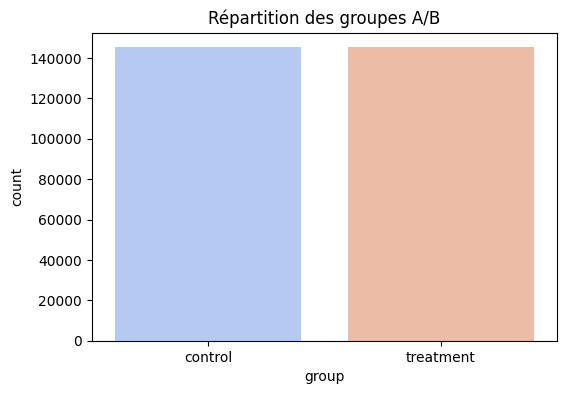

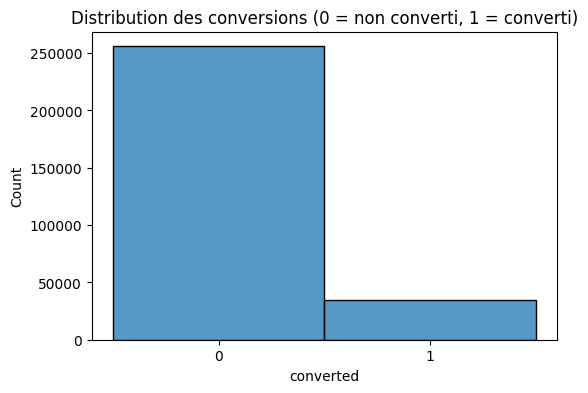

🔹 Taux de conversion global : 11.96%

🔹 Taux de conversion par groupe :
group
control      12.038630
treatment    11.880725
Name: converted, dtype: float64


In [20]:
# Distribution des groupes (Control vs Treatment)
plt.figure(figsize=(6,4))
sns.countplot(x=df["group"], palette="coolwarm")
plt.title("Répartition des groupes A/B")
plt.show()

# Distribution des taux de conversion
plt.figure(figsize=(6,4))
sns.histplot(df["converted"], bins=2, kde=False, discrete=True)
plt.title("Distribution des conversions (0 = non converti, 1 = converti)")
plt.xticks([0, 1])
plt.show()

# Taux de conversion global
conversion_rate = df["converted"].mean() * 100
print(f"🔹 Taux de conversion global : {conversion_rate:.2f}%")

# Taux de conversion par groupe
conversion_by_group = df.groupby("group")["converted"].mean() * 100
print("\n🔹 Taux de conversion par groupe :")
print(conversion_by_group)


### Analyse Bivariée (Relation entre les variables)

C:\Users\yohar\AppData\Local\Temp\ipykernel_58064\2994953612.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["group"], y=df["converted"], palette="coolwarm")


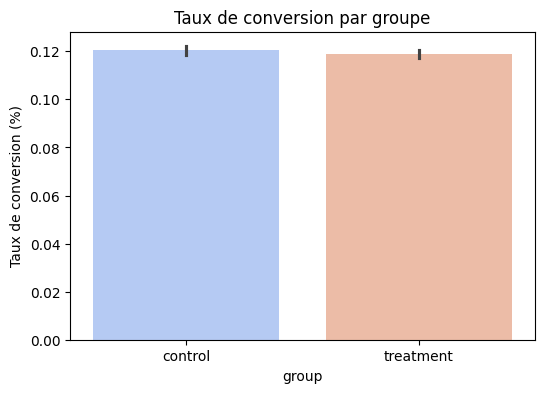

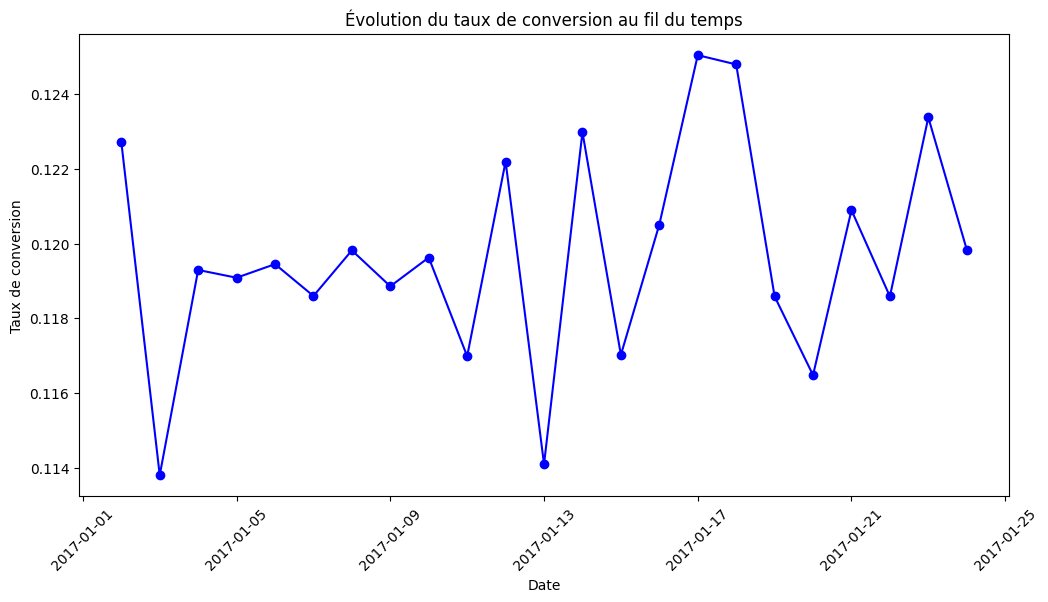

C:\Users\yohar\AppData\Local\Temp\ipykernel_58064\2994953612.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["landing_page"], y=df["converted"], palette="coolwarm")


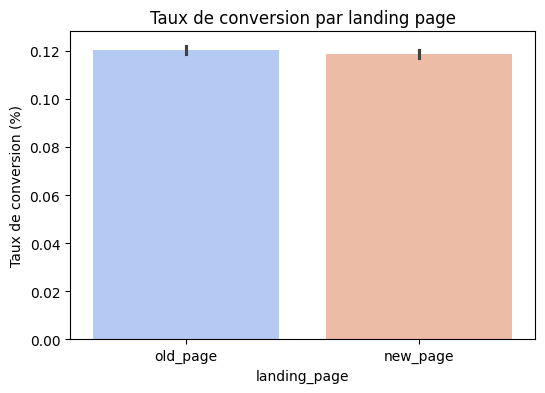

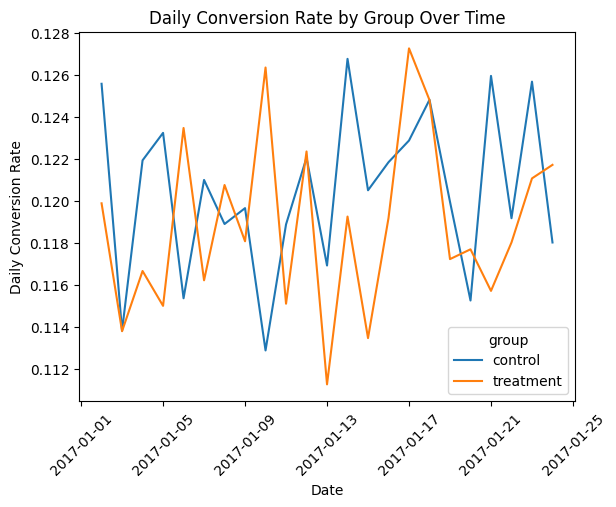

In [28]:
# Comparaison du taux de conversion entre les groupes
plt.figure(figsize=(6,4))
sns.barplot(x=df["group"], y=df["converted"], palette="coolwarm")
plt.title("Taux de conversion par groupe")
plt.ylabel("Taux de conversion (%)")
plt.show()

# Évolution du taux de conversion au fil du temps
df["date"] = df["timestamp"].dt.date
daily_conversion = df.groupby("date")["converted"].mean()

plt.figure(figsize=(12,6))
plt.plot(daily_conversion, marker="o", linestyle="-", color="b")
plt.title("Évolution du taux de conversion au fil du temps")
plt.xlabel("Date")
plt.ylabel("Taux de conversion")
plt.xticks(rotation=45)
plt.show()

# Segmentation des taux de conversion par landing page
plt.figure(figsize=(6,4))
sns.barplot(x=df["landing_page"], y=df["converted"], palette="coolwarm")
plt.title("Taux de conversion par landing page")
plt.ylabel("Taux de conversion (%)")
plt.show()

df['timestamp'] = pd.to_datetime(df['timestamp'])
df_time = df.set_index('timestamp')
daily_conversions = df_time.groupby(['group']).resample('D')['converted'].mean().reset_index()

sns.lineplot(x='timestamp', y='converted', hue='group', data=daily_conversions)
plt.title("Daily Conversion Rate by Group Over Time")
plt.ylabel("Daily Conversion Rate")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()


Observation :
Les taux de conversion fluctuent fortement au jour le jour.
Les groupes control (ancienne page) et treatment (nouvelle page) montrent des variations similaires au fil du temps.
Aucune tendance claire n’indique qu’un groupe a un avantage stable.
À plusieurs moments, les lignes se croisent, ce qui signifie qu’aucun des groupes ne domine de manière significative.

Conséquence :
Le facteur temporel n’introduit pas de biais majeur dans les conversions.
Il n’y a pas de moment précis où la nouvelle page surpasserait systématiquement l’ancienne.
Cela renforce l’idée que la différence observée est due au hasard et non à une tendance réelle.

### Vérification des Hypothèses et Normalité des Données

In [22]:
from scipy.stats import shapiro

# Vérifier la normalité des conversions
stat, p_value = shapiro(df["converted"])
print(f"\n🔹 Test de Shapiro-Wilk pour la normalité : p-value = {p_value:.4f}")

if p_value < 0.05:
    print(" Les données ne suivent pas une distribution normale.")
else:
    print(" Les données suivent une distribution normale.")



🔹 Test de Shapiro-Wilk pour la normalité : p-value = 0.0000
 Les données ne suivent pas une distribution normale.


c:\Users\yohar\miniconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 290585.
  res = hypotest_fun_out(*samples, **kwds)


### Mise en place de l’A/B Testing Approfondi

Test du Chi² (Comparaison des proportions de conversions)

In [23]:
from scipy.stats import chi2_contingency

# Construction du tableau de contingence
contingency_table = pd.crosstab(df["group"], df["converted"])
print("\n🔹 Tableau de contingence :")
print(contingency_table)

# Test du Chi²
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"\n🔹 Test du Chi² : Statistique = {chi2:.2f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print(" Il y a une différence significative entre les deux groupes.")
else:
    print(" Aucune différence significative entre les groupes.")



🔹 Tableau de contingence :
converted       0      1
group                   
control    127785  17489
treatment  128047  17264

🔹 Test du Chi² : Statistique = 1.71, p-value = 0.1916
 Aucune différence significative entre les groupes.


Test de Student (T-Test)

In [24]:
from scipy.stats import ttest_ind

# Séparer les groupes
group_A = df[df["group"] == "control"]["converted"]
group_B = df[df["group"] == "treatment"]["converted"]

# Test de Student
t_stat, p_value = ttest_ind(group_A, group_B)

print(f"\n🔹 Test de Student : Statistique = {t_stat:.2f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print(" Il y a une différence significative entre les deux groupes.")
else:
    print(" Aucune différence significative entre les groupes.")



🔹 Test de Student : Statistique = 1.31, p-value = 0.1897
 Aucune différence significative entre les groupes.


Test de Mann-Whitney (Si les distributions ne sont pas normales)

In [25]:
from scipy.stats import mannwhitneyu

# Test de Mann-Whitney
u_stat, p_value = mannwhitneyu(group_A, group_B, alternative="two-sided")

print(f"\n🔹 Test de Mann-Whitney : Statistique = {u_stat:.2f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print(" Il y a une différence significative entre les deux groupes.")
else:
    print(" Aucune différence significative entre les groupes.")



🔹 Test de Mann-Whitney : Statistique = 10571621978.50, p-value = 0.1897
 Aucune différence significative entre les groupes.


### Conclusion & Recommandations : <br>
La nouvelle page ne convertit pas mieux que l’ancienne.<br>
Les fluctuations temporelles n’apportent pas d’explication au manque de différence.<br>
Les tests statistiques confirment que l’impact est insignifiant.

### Recommandations possibles : <br> 
`Ne pas implémenter la nouvelle page`, car elle n'apporte aucun gain.<br>
 `Tester d’autres variantes de la landing page` (différents designs, messages, CTA).<br>
 `Analyser d’autres facteurs` (temps passé sur la page, taux de rebond).